# Robustness and Exploration of Variational and Machine Learning Approaches to Inverse Problems

## Imports and setup

In [1]:
%reload_ext autoreload
%autoreload 2

#%env CUBLAS_WORKSPACE_CONFIG=:16:8
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import os
from pathlib import Path
import random
from typing import Tuple

import matplotlib.pyplot  as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchopt
from tqdm.auto import tqdm, trange

from unet import UNet
from tiramisu import Tiramisu
from itnet import ItNet

plt.rcParams.update({
    "text.usetex": True,
    "font.family" : "sans-serif",
    "font.weight" : "bold",
    "font.size"   : 22
})

torch.set_grad_enabled(False)
torch.set_default_dtype(torch.float64)

def seed(seed: int):
    if seed < 0:
        return
    seed = seed%2^32
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=True)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Configuration

In [2]:
SEED = 314176
seed(SEED)
DEVICE = torch.device("cuda:0")
NUM_WORKERS = 0 #os.cpu_count()

N_TRAIN_SAMPLES = 1024 # 64% * 1600
N_VAL_SAMPLES = 256    # 16% * 1600
N_TEST_SAMPLES = 320   # 20% * 1600
NOISE_LEVEL_VALTEST = 0.03 # 0.0
NOISE_LEVEL_TRAIN = NOISE_LEVEL_VALTEST # 0.0
BATCH_SIZE = 128

DATA_SIZE = 1024
MEASUREMENT_SIZE = 512

In [3]:
TV_CALC_BOUNDS = True

TV_SOLVER = lambda x: globals()["tv_admm"](x)
# SGD
#TV_LR = 3e-2
#TV_ALPHA = 1e1
#TV_ITERATIONS = 1000
# ADMM
TV_ITERATIONS = 2_200
TV_LAMBDA = 1e0
TV_ALPHA = 1e0
# PDHG 1
#TV_ALPHA = 1e-2
#TV_ITERATIONS = 50
#TV_TAU = 1e2
#TV_SIGMA = TV_TAU
# PDHG 2
#TV_ITERATIONS = 5000
#TV_TAU = 9e-4
#TV_SIGMA = TV_TAU
#TV_ALPHA = 1e1


TV_ADV_LR = 1e1
TV_ADV_ITERATIONS = 1
TV_ADV_EPSILON = 2e-1


TIK_ALPHA = 0.1

In [4]:
UNET_DO_TRAIN = True
UNET_WEIGHTS_PATH = None  # Path("train/unet_noisy/weights.pth")
UNET_LR = 1e-3
UNET_EPOCHS = 75

UNET_ADV_LR = 1e1
UNET_ADV_ITERATIONS = 1
UNET_ADV_EPSILON = 2e-1

In [5]:
TIRAMISU_DO_TRAIN = True
TIRAMISU_WEIGHTS_PATH = None  # Path("train/tiramisu_noisy/weights.pth")
TIRAMISU_LR = 1e-4
TIRAMISU_EPOCHS = 150

TIRAMISU_ADV_LR = 1e1
TIRAMISU_ADV_ITERATIONS = 1
TIRAMISU_ADV_EPSILON = 2e-1

In [6]:
ITNET_INTERN_LR = 1e-3
ITNET_INTERN_ITERATIONS = 5

ITNET_DO_TRAIN = True
ITNET_WEIGHTS_PATH = None  # Path("train/itnet_noisy/weights.pth")
ITNET_LR = 1e-3
ITNET_EPOCHS = 75

ITNET_ADV_LR = 1e1
ITNET_ADV_ITERATIONS = 1
ITNET_ADV_EPSILON = 2e-1

## Operators

In [7]:
#__A = torch.eye(DATA_SIZE, device=DEVICE).unsqueeze(0)
__A = 0.05*torch.randn((MEASUREMENT_SIZE,DATA_SIZE), device=DEVICE).unsqueeze(0)
__AI = __A@torch.tril(torch.ones((1,DATA_SIZE,DATA_SIZE), device=DEVICE))
__AITAIpIi = (__AI.mT@__AI + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__lAITAIpIi = ((TV_LAMBDA if "TV_LAMBDA" in globals().keys() else 1.0)*__AI.mT@__AI + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__D = torch.eye(DATA_SIZE, device=DEVICE)-torch.diag(torch.ones((DATA_SIZE-1), device=DEVICE), -1).unsqueeze(0)
__ATApaD2iAT = (__A.mT@__A+TIK_ALPHA*__D.mT@__D).inverse()@__A.mT  # USE __tmp instead of __A?
A = lambda x: (__A@x.unsqueeze(-1))[...,0]
A_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0]
AI = lambda x: (__A@x.cumsum(1).unsqueeze(-1))[...,0]
AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
AITAIpIi = lambda x: (__AITAIpIi@x.unsqueeze(-1))[...,0]
lAITAIpIi = lambda x: (__lAITAIpIi@x.unsqueeze(-1))[...,0]
A_pinv = lambda x: (__ATApaD2iAT@x.unsqueeze(-1))[...,0]

#x = torch.randn((1,DATA_SIZE), device=DEVICE)
#y = torch.randn((1,MEASUREMENT_SIZE), device=DEVICE)
#print(torch.sum(A(x)*y)-torch.sum(A_T(y)*x))

## Data generation

In [8]:
def generate_signals(
    N_samples: int,
    noise_level: float = 0.03,
    N_signal: int = 1000,
    min_jumps: int = 10, 
    max_jumps: int = 20, 
    min_distance: int = 40, 
    boundary_width: int = 20, 
    height_std: float = 1.0,
    min_height: float = 0.2
) -> Tensor:
    #Calculate positions by generating min_distance-spaced positions
    #and randomly rightshifting by the cumulatice sum
    derivative = torch.zeros((N_samples,N_signal), device=DEVICE)
    for i in range(N_samples):
        jump_count = random.randint(min_jumps-2, max_jumps-2)
        delta = torch.rand((jump_count-1), device=DEVICE) # One more than needed (last will be discarded, as it would lead to using the right boundary as last value, due to the normalization)
        delta = torch.cumsum((N_signal-2*boundary_width-(jump_count-2)*min_distance)*delta/delta.sum(), 0)[:-1].ceil().to(torch.long)
        jump_positions = boundary_width+min_distance*torch.arange(jump_count-2, device=DEVICE)+delta.sort()[0]
        values = height_std*torch.randn((jump_count,), device=DEVICE)
        values[torch.abs(values)<min_height] = values[torch.abs(values)<min_height].sign()*min_height
        derivative[i,torch.cat([torch.tensor([0], device=DEVICE),jump_positions,torch.tensor([0], device=DEVICE)])] = values
    groundtruths = derivative.cumsum(1)
    measurements = A(groundtruths)
    noisy_measurement = measurements+noise_level*torch.randn_like(measurements)
    return noisy_measurement, groundtruths

/tmp/ipykernel_4141484/4215437499.py:18: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  delta = torch.cumsum((N_signal-2*boundary_width-(jump_count-2)*min_distance)*delta/delta.sum(), 0)[:-1].ceil().to(torch.long)
/tmp/ipykernel_4141484/4215437499.py:23: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  groundtruths = derivative.cumsum(1)


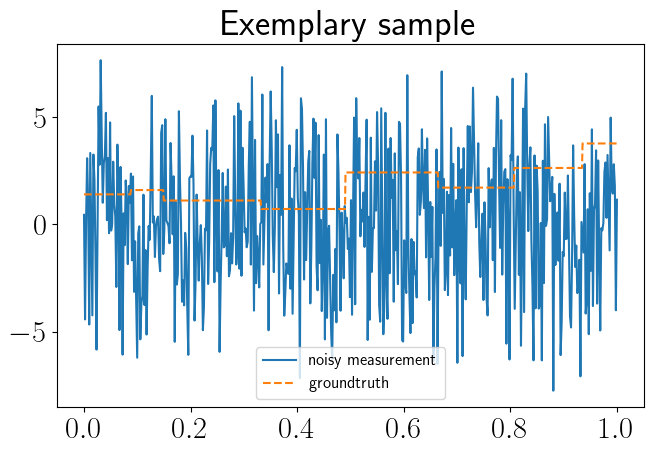

In [9]:
train_dataset = TensorDataset(*generate_signals(N_TRAIN_SAMPLES, noise_level=NOISE_LEVEL_TRAIN, N_signal=DATA_SIZE))
val_dataset = TensorDataset(*generate_signals(N_VAL_SAMPLES, noise_level=NOISE_LEVEL_VALTEST, N_signal=DATA_SIZE))
test_dataset = TensorDataset(*generate_signals(N_TEST_SAMPLES, noise_level=NOISE_LEVEL_VALTEST, N_signal=DATA_SIZE))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))

noisy_measurement, groundtruth = train_dataset[0]
plt.figure(figsize=(7,5))
plt.title("Exemplary sample")
plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[0]), noisy_measurement.detach().to("cpu").numpy(), label="noisy measurement")
plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[0]), groundtruth.detach().to("cpu").numpy(), "--", label="groundtruth")
plt.legend(prop={"size": 12})
plt.tight_layout()
plt.show()

## Utilities

In [10]:
class TensorModule(nn.Module):
    def __init__(self, initial_value: Tensor) -> None:
        super().__init__()
        self.__tensor = torch.nn.parameter.Parameter(initial_value)
    
    @property
    def tensor(self) -> torch.Tensor:
        return self.__tensor

In [11]:
def total_variation(x: Tensor) -> Tensor:
    return F.conv1d(x.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1).abs().mean()

## Algorithms

### Tikhonov

  0%|          | 0/3 [00:00<?, ?it/s]

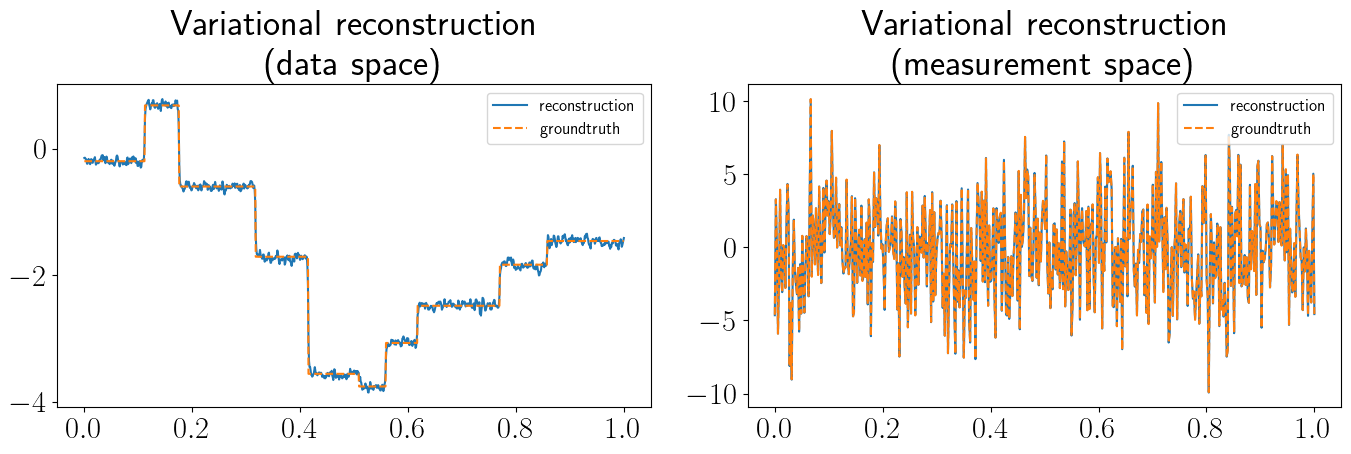

Loss: 0.00484
MSE: 0.00484


In [12]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction, tv_loss, subgradient = A_pinv(noisy_measurement), F.mse_loss(A_pinv(noisy_measurement), groundtruth), None
    # ---------------- Evaluation --------------------
    loss_acc += tv_loss
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("Variational reconstruction\n(data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("Variational reconstruction\n(measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### TV-Regularized energy minimization

#### Solvers

In [13]:
def tv_gd(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    reconstruction = TensorModule(torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE))
    optimizer = torchopt.MetaAdam(reconstruction, lr=TV_LR)
    with torch.enable_grad():
        for _ in range(TV_ITERATIONS):
            loss = F.mse_loss(A(reconstruction.tensor), noisy_measurement) + TV_ALPHA*total_variation(reconstruction.tensor)
            optimizer.step(loss)
    return reconstruction.tensor, loss.item(), None

https://www.stat.cmu.edu/~ryantibs/convexopt-F18/lectures/admm.pdf
$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(u)\\
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
%\operatorname{prox}_{\lambda G}(u) = (A^TA+I)^{-1}(\frac{u+A^Tf}{\lambda})\\
\operatorname{prox}_{\lambda G}(u) = (\lambda A^TA+I)^{-1}(u+\lambda A^Tf)\\
F(u) = \alpha\|u\|_1\\
\operatorname{prox}_{\lambda F}(u) = \operatorname{sign}(u)\max(|u|-\lambda\alpha,0)
$$

In [14]:
def tv_admm(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    prox_G = lambda u: lAITAIpIi(u+TV_LAMBDA*AI_T(noisy_measurement))
    prox_F = lambda u: u.sign()*torch.clamp(u.abs()-TV_LAMBDA*TV_ALPHA, 0.0)
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    z = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    for i in range(TV_ITERATIONS):
        x = prox_F(y-z)
        y = prox_G(x+z)
        z = z+x-y
        #if i%100==0:
        #    print(torch.sum(torch.abs(y[0]-x[0])))
        #    print(torch.sum((-z/TV_ALPHA)[0]*y[0] - torch.abs(y[0])))
    # p = -z/TV_ALPHA / TV_LAMBDA ist der subgradient von ||y||_1 also ist D^T p Subgradient von ||Du||_1 im Bezug auf u. ->> 
    # Zurückgeben und <p¹-p², y¹-y²> +1/2 ||Ay¹ - Ay²||² ausrechnen und mit 1/2 ||f¹ - f²||² vergleichen.
    x = x.cumsum(1)
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), -z/(TV_ALPHA*TV_LAMBDA) #F.conv_transpose1d((-z/(TV_ALPHA*TV_LAMBDA)).unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = \frac{1}{2}\|Au-f\|_2^2\\
K = I\\
F(u) = \alpha\|u\|_1\\
\begin{aligned}
F^*(u^*) &= \max_u \langle u,u^*\rangle - \alpha\|u\|_1 \\
         &= \max_u \langle u,u^*\rangle - \alpha\max_{p,\|p\|_\infty\le 1} \langle u, p\rangle\\
         &= \max_u \langle u,u^*\rangle + \alpha\min_{p,\|p\|_\infty\le 1} -\langle u, p\rangle\\
         &= \max_u \min_{p,\|p\|_\infty\le 1} \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \max_u \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \begin{cases}0&\text{if }u^* = \alpha p\\\infty&\text{else}\end{cases}\\
         &= \begin{cases}0&\text{if }\|u^*\|_\infty\le \alpha\\\infty&\text{else}\end{cases}\\
         &= \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

$$
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \tau\frac{1}{2}\|Az-f\|_2^2+\frac{1}{2}\|z-u\|_2^2\\
                                &= (A^TA+I)^{-1}\left(\frac{u}{\tau}+A^Tf\right)\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \argmin_z \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \argmin_{z,\|z\|_\infty\le\alpha} \frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \mathcal{P}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

In [15]:
def tv_pdhg1(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    prox_G = lambda u: AITAIpIi(u/TV_TAU+AI_T(noisy_measurement))
    prox_F_star = lambda u_star: torch.clamp(u_star, -TV_ALPHA, TV_ALPHA)
    K = AI
    K_T = AI_T
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    x = x.cumsum(1)
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), None

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = 0\\
K = \begin{pmatrix}A\\I\end{pmatrix}\\
F(u) = \frac{1}{2}\|u_1-f\|_2^2+\alpha\|u_2\|_1\\
\begin{aligned}
F^*(u^*) &= \begin{pmatrix}\max\limits_{u_1}\langle u_1, u_1^*\rangle - \frac{1}{2}\|u_1-f\|_2^2\\\max\limits_{u_2}\langle u_2, u_2^*\rangle - \alpha\|u_2\|_1\end{pmatrix}\\
         &= \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

$$
G(u) = 0\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \frac{1}{2}\|z-u\|_2^2\\
                                &= u\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \begin{pmatrix}\argmin\limits_{z} \sigma\frac{1}{2}\|z\|_2^2 + \sigma\langle f, z\rangle+\frac{1}{2}\|z-u^*_1\|_2^2\\
                                                      \argmin\limits_{z} \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*_2\|_2^2\end{pmatrix}\\
                                    &= \begin{pmatrix}\frac{u^*_1-\sigma f}{1+\sigma}\\
                                                      \mathcal{P}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

In [16]:
def tv_pdhg2(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    prox_G = lambda u: u
    prox_F_star = lambda u_star: torch.cat([
        (u_star[:,:MEASUREMENT_SIZE]-TV_SIGMA*noisy_measurement)/(1.0+TV_SIGMA), 
        torch.clamp(u_star[:,MEASUREMENT_SIZE:], -TV_ALPHA, TV_ALPHA)
    ], dim=1)
    K = lambda u: torch.cat([
        AI(u),
        #F.conv1d(u.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0],
        u
    ], dim=1)
    K_T = lambda u_star:\
        AI_T(u_star[:,:MEASUREMENT_SIZE])+\
        u_star[:,MEASUREMENT_SIZE:]
        #F.conv_transpose1d(u_star[:,s1:].unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE+DATA_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    x = x.cumsum(1)
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), None

#### \_\_DUMMY\_\_

#### Upper bound

In [17]:
if TV_CALC_BOUNDS:
    loss_acc = 0.0
    mse_acc = 0.0
    values = []
    #bounds = []
    for _ in trange(1):
        for noisy_measurement, groundtruth in test_dataloader:
            # ---------------- Adversarial attack ------------
            adversarial_measurement = noisy_measurement.clone()
            adversarial_measurement.requires_grad = True
            for _ in range(TV_ADV_ITERATIONS):
                with torch.enable_grad():
                    reconstruction = TV_SOLVER(adversarial_measurement)[0]
                    loss = F.mse_loss(reconstruction, groundtruth)
                    loss.backward()
                adversarial_measurement = adversarial_measurement + TV_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
                adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TV_ADV_EPSILON, TV_ADV_EPSILON) # Projection
                adversarial_measurement.requires_grad = True
            # ---------------- Reconstruction ----------------
            reconstruction, tv_loss, subgradient = TV_SOLVER(noisy_measurement)
            reconstruction_adv, tv_loss_adv, subgradient_adv = TV_SOLVER(adversarial_measurement)
            value = torch.sum((subgradient-subgradient_adv)*(reconstruction-reconstruction_adv), dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction_adv), 2.0).sum(dim=1)
            #bound = 0.5*torch.pow(noisy_measurement-adversarial_measurement, 2.0).sum(dim=1)
            values.extend(value.tolist())
            #bounds.extend(bound.tolist())
values = 2.0*torch.tensor(values)/MEASUREMENT_SIZE
#bounds = 2.0*torch.tensor(bounds)/MEASUREMENT_SIZE

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_4141484/1101476556.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_4141484/4244571049.py:16: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)
/home/alexander/anaconda3/envs/GAMM/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: cumsum_cuda_kernel 

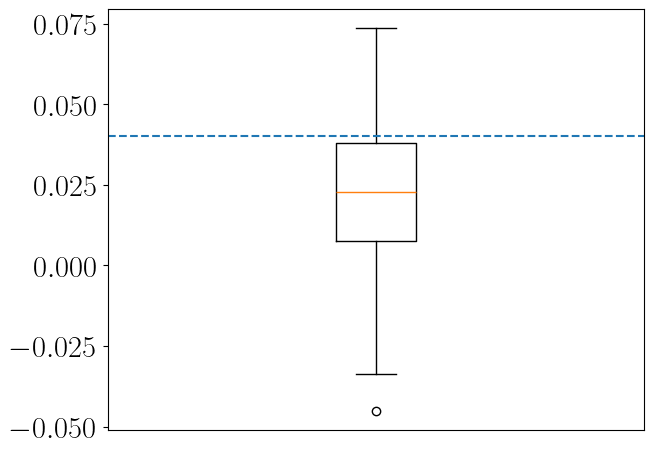

In [18]:
"""plt.subplots(figsize=(7,5),sharey=True)
plt.boxplot(values.flatten(), positions=[0.5])
plt.boxplot(bounds.flatten(), positions=[1.5])
plt.xticks([0.5,1.5], ["Value", "Bound"])
plt.plot(torch.linspace(0.0, 2.0, 10), torch.full((10,), TV_ADV_EPSILON**2), "--")
plt.tight_layout()
plt.show()"""

plt.subplots(figsize=(7,5),sharey=True)
plt.boxplot(values.flatten(), positions=[0.5])
plt.xticks([])
plt.plot(torch.linspace(0.0, 1.0, 10), torch.full((10,), TV_ADV_EPSILON**2), "--")
plt.tight_layout()
plt.show()

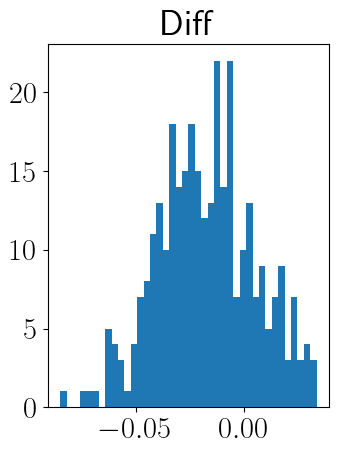

247 320


In [19]:
#diff = (values-bounds).flatten()
diff = (values-TV_ADV_EPSILON**2).flatten()
plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.title("Diff")
plt.hist(diff, bins=40)
plt.tight_layout()
plt.show()
print((diff<0).sum().item(), diff.numel())

#### Experiments

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_4141484/1101476556.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_4141484/4244571049.py:16: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)


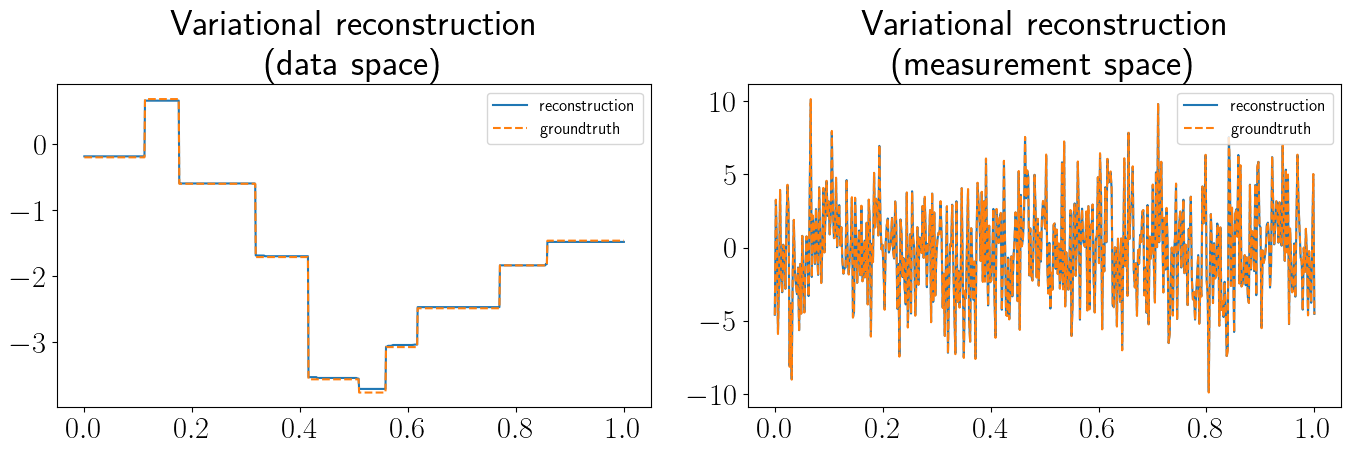

Loss: 0.01119
MSE: 0.00058


In [20]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction, tv_loss, subgradient = TV_SOLVER(noisy_measurement)
    # ---------------- Evaluation --------------------
    loss_acc += tv_loss
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("Variational reconstruction\n(data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("Variational reconstruction\n(measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_4141484/1101476556.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_4141484/4244571049.py:16: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)
/home/alexander/anaconda3/envs/GAMM/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: cumsum_cuda_kernel 

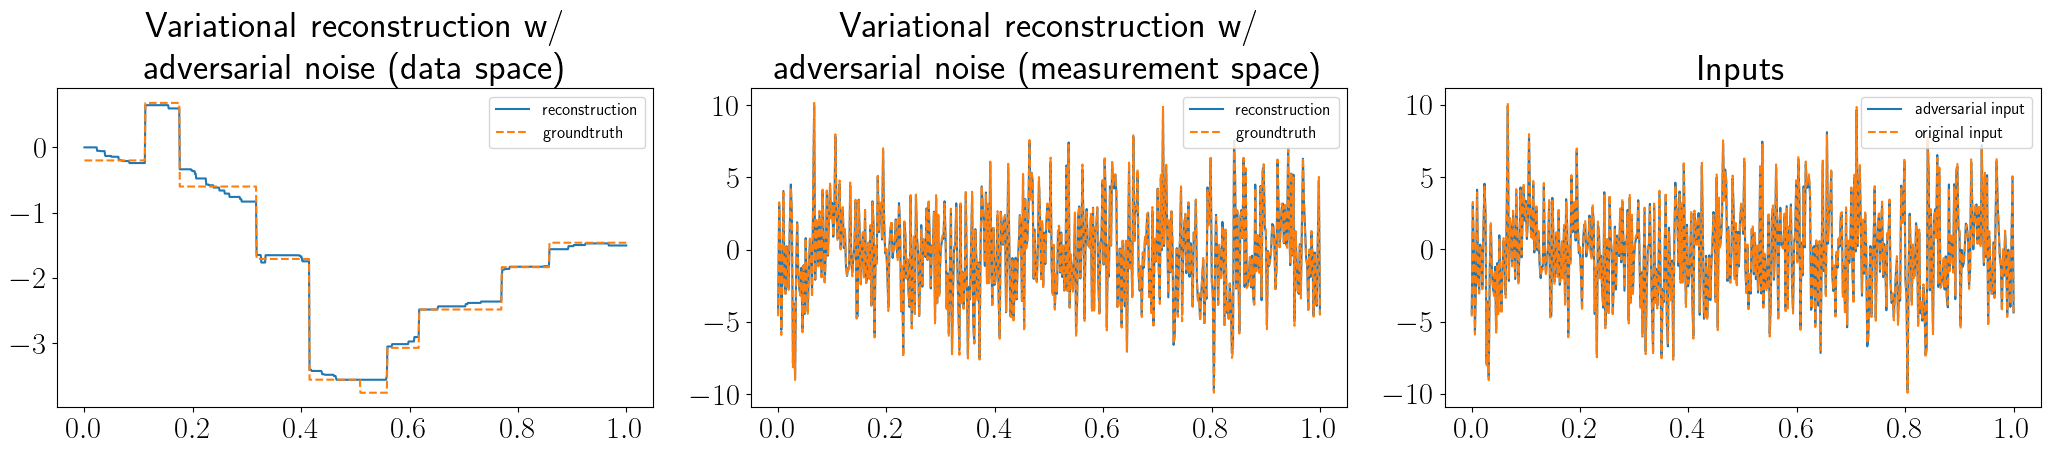

Loss: 0.02471
MSE: 0.01188


In [21]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(TV_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = TV_SOLVER(adversarial_measurement)[0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + TV_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TV_ADV_EPSILON, TV_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction, tv_loss, subgradient = TV_SOLVER(adversarial_measurement)
    # ---------------- Evaluation --------------------
    loss_acc += tv_loss
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("Variational reconstruction w/\nadversarial noise (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("Variational reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### Post-processing U-Net

In [22]:
unet = UNet(1, 1, A_pinv, dims=1).to(DEVICE)
loss_fn = lambda a,b: F.mse_loss(a,b)
if UNET_WEIGHTS_PATH is not None:
    unet.load_state_dict(torch.load(str(UNET_WEIGHTS_PATH.resolve())))

  0%|          | 0/75 [00:00<?, ?it/s]

/home/alexander/anaconda3/envs/GAMM/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


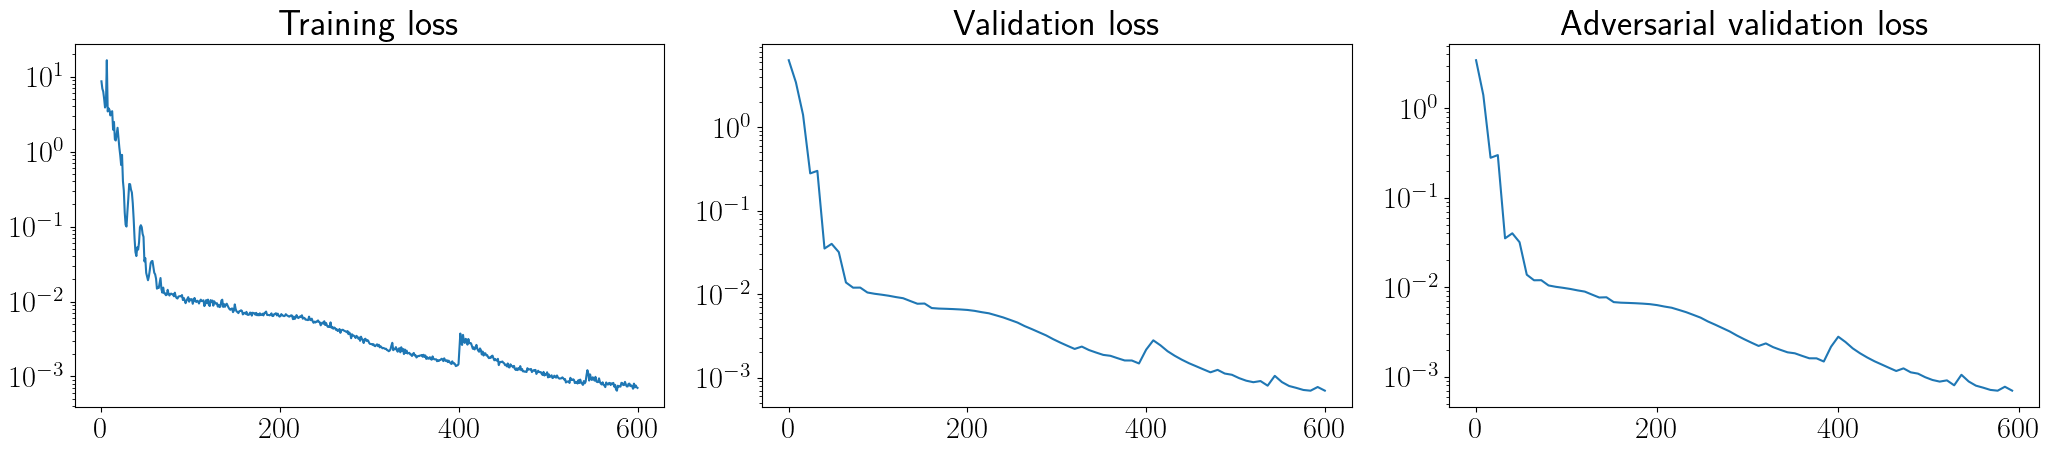

In [23]:
UNET_EPOCHS = 75 #45
UNET_LR = 1e-3 #1e-3



assert UNET_WEIGHTS_PATH is not None or UNET_DO_TRAIN
if UNET_DO_TRAIN:
    optimizer = torch.optim.Adam(unet.parameters(), lr=UNET_LR, foreach=False)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
    train_losses = []
    val_losses = []
    val_adv_losses = []
    loss_acc = 0.0
    for noisy_measurement, groundtruth in val_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Forward ----------------
        reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
        # ---------------- Evaluation -------------
        loss_acc += loss_fn(reconstruction, groundtruth).item()
    val_losses.append(loss_acc/len(val_dataloader))
    for _ in trange(UNET_EPOCHS):
        unet.train()
        for noisy_measurement, groundtruth in train_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Training ---------------
            with torch.enable_grad():
                reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
                loss = loss_fn(reconstruction, groundtruth)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ---------------- Evaluation -------------
            train_losses.append(loss_fn(reconstruction, groundtruth).item())
        unet.eval()
        loss_acc = 0.0
        adv_loss_acc = 0.0
        for noisy_measurement, groundtruth in val_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Forward ----------------
            reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
            # ---------------- Evaluation -------------
            loss_acc += loss_fn(reconstruction, groundtruth).item()
            # ------------ Adversarial attack ---------
            adversarial_measurement = noisy_measurement.clone()
            adversarial_measurement.requires_grad = True
            for _ in range(UNET_ADV_ITERATIONS):
                with torch.enable_grad():
                    reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
                    loss = loss_fn(reconstruction, groundtruth)
                    loss.backward()
                adversarial_measurement = adversarial_measurement + UNET_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
                adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -UNET_ADV_EPSILON, UNET_ADV_EPSILON) # Projection
                adversarial_measurement.requires_grad = True
            # ----- Adversarial attack evaluation -----
            adv_loss_acc += loss_fn(reconstruction, groundtruth).item()
        val_losses.append(loss_acc/len(val_dataloader))
        val_adv_losses.append(adv_loss_acc/len(val_dataloader))
        lr_scheduler.step(loss_acc/len(val_dataloader))

    save_dir = "unet_noisy"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    torch.save(torch.tensor(train_losses), str(Path(save_dir, "train_losses.pth").resolve()))
    torch.save(torch.tensor(val_losses), str(Path(save_dir, "val_losses.pth").resolve()))
    torch.save(torch.tensor(val_adv_losses), str(Path(save_dir, "val_adv_losses.pth").resolve()))
    torch.save(unet.state_dict(), str(Path(save_dir, "weights.pth").resolve()))

    plt.subplots(1,3,figsize=(21,5))
    plt.subplot(1,3,1)
    plt.title("Training loss")
    plt.plot(train_losses)
    plt.yscale("log")
    plt.subplot(1,3,2)
    plt.title("Validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
    plt.yscale("log")
    plt.subplot(1,3,3)
    plt.title("Adversarial validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_adv_losses))], val_adv_losses)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

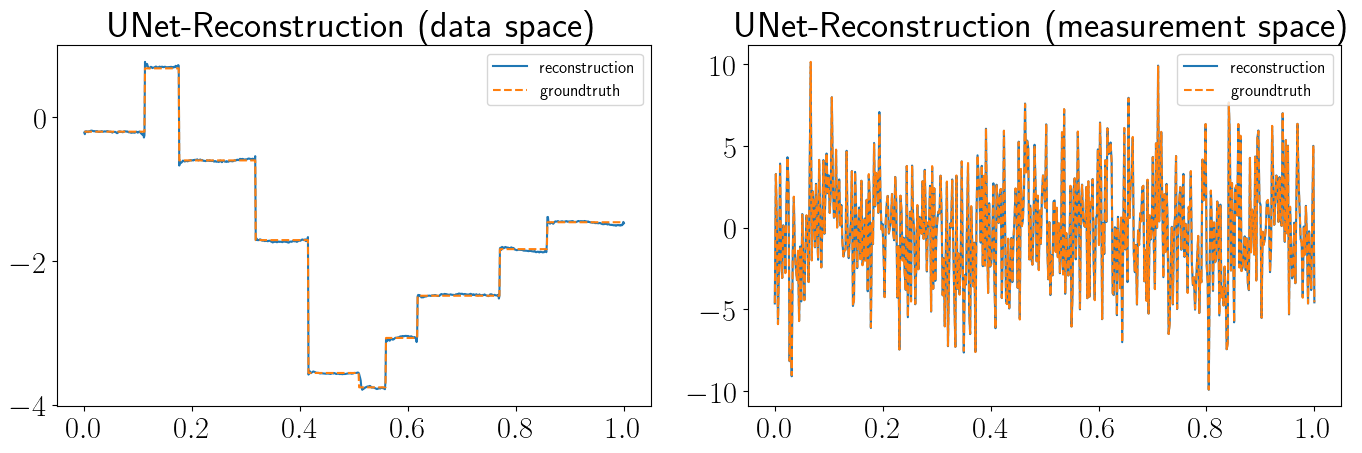

Loss: 0.00072
MSE: 0.00072


In [24]:
loss_acc = 0.0
mse_acc = 0.0
unet.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("UNet-Reconstruction (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("UNet-Reconstruction (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

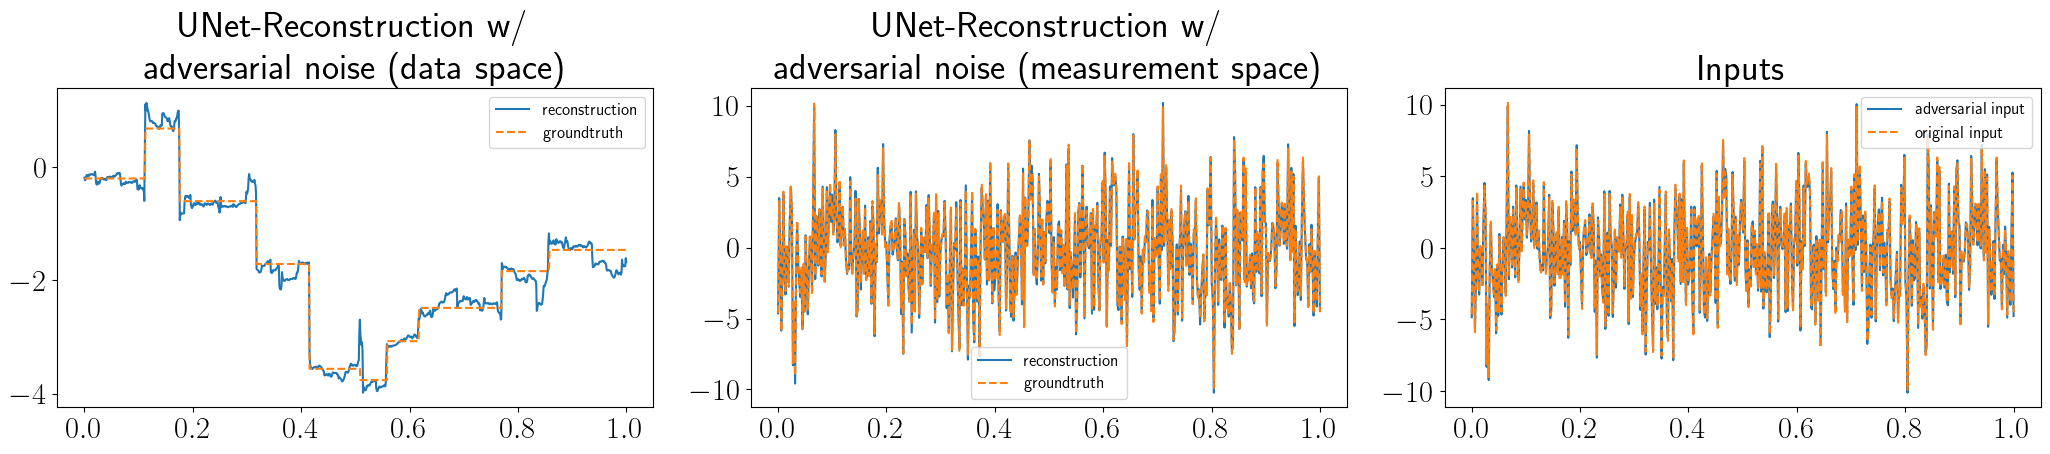

Loss: 0.03763
MSE: 0.03763


In [25]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(UNET_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
            loss = loss_fn(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + UNET_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -UNET_ADV_EPSILON, UNET_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation --------------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("UNet-Reconstruction w/\nadversarial noise (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("UNet-Reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### End-2-End Tiramisu

In [32]:
tiramisu = Tiramisu(1, 1, MEASUREMENT_SIZE, DATA_SIZE, dims=1).to(DEVICE)
loss_fn = lambda a,b: F.mse_loss(a, b)
if TIRAMISU_WEIGHTS_PATH is not None:
    tiramisu.load_state_dict(torch.load(str(TIRAMISU_WEIGHTS_PATH.resolve())))

  0%|          | 0/75 [00:00<?, ?it/s]

/home/alexander/anaconda3/envs/GAMM/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


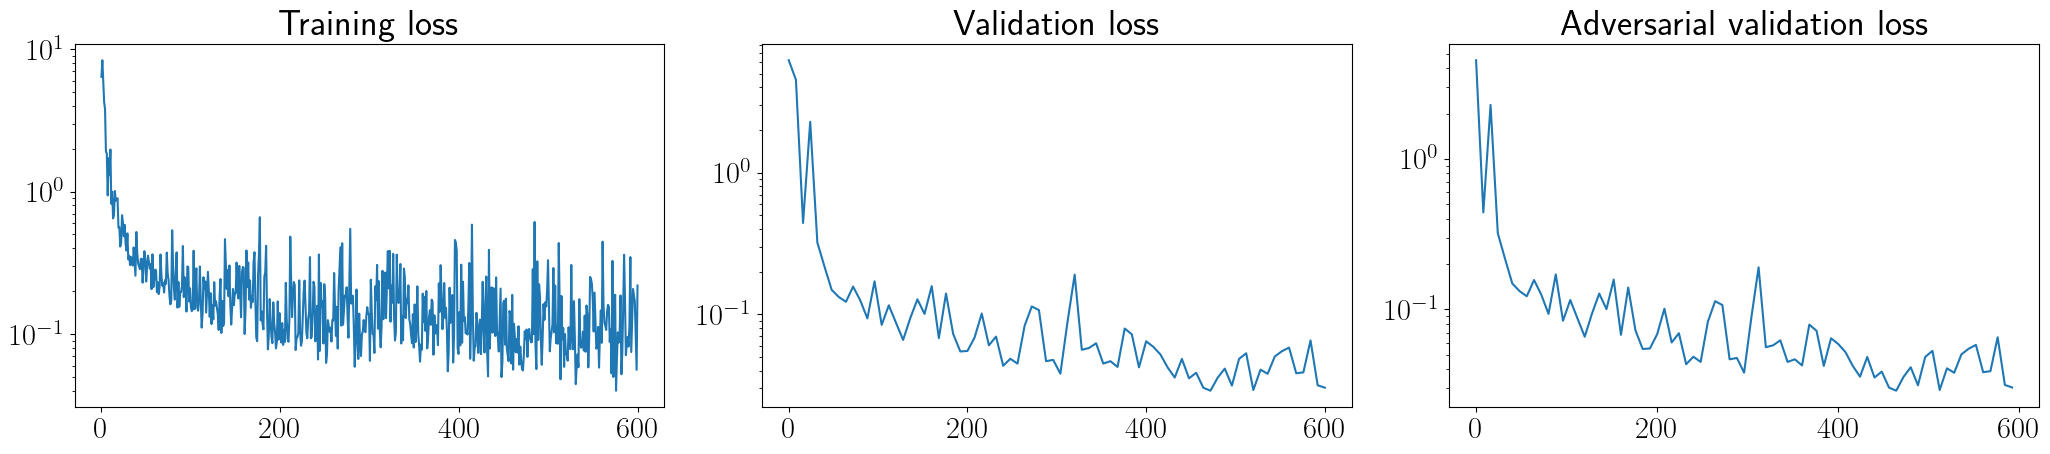

In [33]:
assert TIRAMISU_WEIGHTS_PATH is not None or TIRAMISU_DO_TRAIN
if TIRAMISU_DO_TRAIN:
    optimizer = torch.optim.Adam(tiramisu.parameters(), lr=TIRAMISU_LR, foreach=False)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
    train_losses = []
    val_losses = []
    val_adv_losses = []
    loss_acc = 0.0
    for noisy_measurement, groundtruth in val_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Forward ----------------
        reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
        # ---------------- Evaluation -------------
        loss_acc += loss_fn(reconstruction, groundtruth).item()
    val_losses.append(loss_acc/len(val_dataloader))
    for _ in trange(TIRAMISU_EPOCHS):
        tiramisu.train()
        for noisy_measurement, groundtruth in train_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Training ---------------
            with torch.enable_grad():
                reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
                loss = loss_fn(reconstruction, groundtruth)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ---------------- Evaluation -------------
            train_losses.append(loss_fn(reconstruction, groundtruth).item())
        tiramisu.eval()
        loss_acc = 0.0
        adv_loss_acc = 0.0
        for noisy_measurement, groundtruth in val_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Forward ----------------
            reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
            # ---------------- Evaluation -------------
            loss_acc += loss_fn(reconstruction, groundtruth).item()
            # ------------ Adversarial attack ---------
            adversarial_measurement = noisy_measurement.clone()
            adversarial_measurement.requires_grad = True
            for _ in range(TIRAMISU_ADV_ITERATIONS):
                with torch.enable_grad():
                    reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
                    loss = loss_fn(reconstruction, groundtruth)
                    loss.backward()
                adversarial_measurement = adversarial_measurement + TIRAMISU_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
                adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TIRAMISU_ADV_EPSILON, TIRAMISU_ADV_EPSILON) # Projection
                adversarial_measurement.requires_grad = True
            # ----- Adversarial attack evaluation -----
            adv_loss_acc += loss_fn(reconstruction, groundtruth).item()
        val_losses.append(loss_acc/len(val_dataloader))
        val_adv_losses.append(adv_loss_acc/len(val_dataloader))
        lr_scheduler.step(loss_acc/len(val_dataloader))

    save_dir = "tiramisu_noisy"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    torch.save(torch.tensor(train_losses), str(Path(save_dir, "train_losses.pth").resolve()))
    torch.save(torch.tensor(val_losses), str(Path(save_dir, "val_losses.pth").resolve()))
    torch.save(torch.tensor(val_adv_losses), str(Path(save_dir, "val_adv_losses.pth").resolve()))
    torch.save(tiramisu.state_dict(), str(Path(save_dir, "weights.pth").resolve()))

    plt.subplots(1,3,figsize=(21,5))
    plt.subplot(1,3,1)
    plt.title("Training loss")
    plt.plot(train_losses)
    plt.yscale("log")
    plt.subplot(1,3,2)
    plt.title("Validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
    plt.yscale("log")
    plt.subplot(1,3,3)
    plt.title("Adversarial validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_adv_losses))], val_adv_losses)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

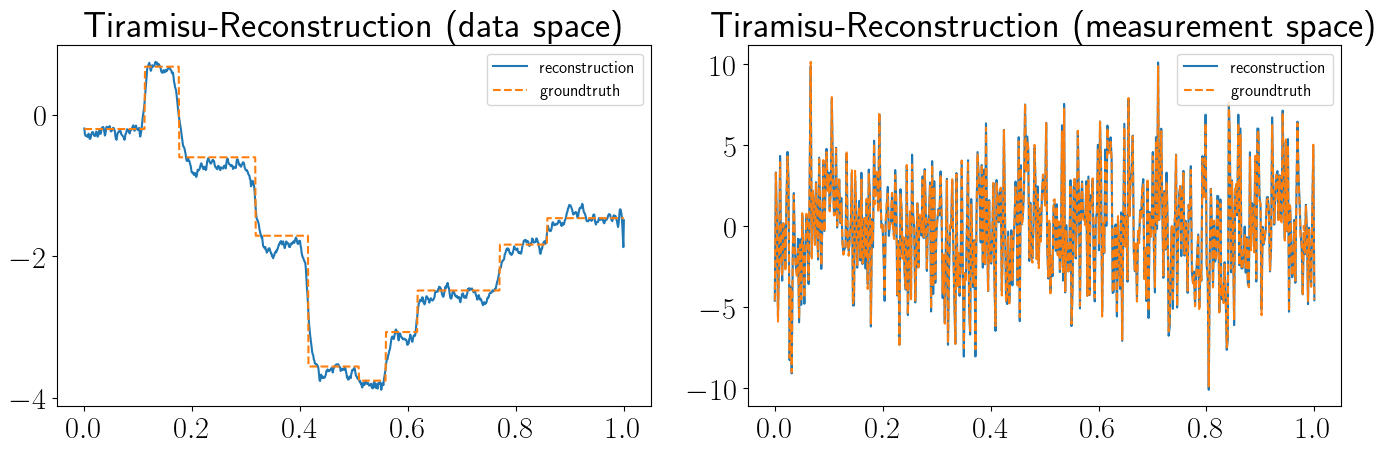

Loss: 0.03125
MSE: 0.03125


In [34]:
loss_acc = 0.0
mse_acc = 0.0
tiramisu.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("Tiramisu-Reconstruction (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("Tiramisu-Reconstruction (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

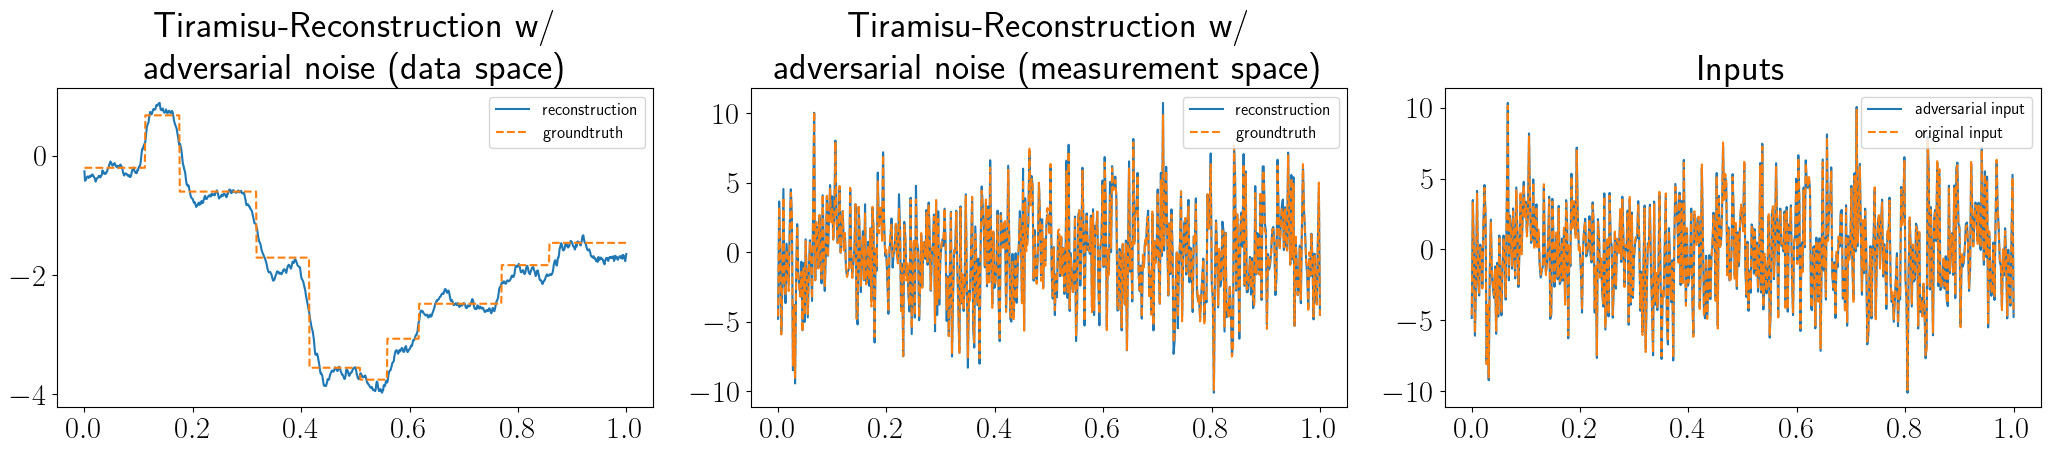

Loss: 0.03146
MSE: 0.06311


In [29]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(TIRAMISU_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
            loss = loss_fn(reconstruction, groundtruth)
            loss.backward()
        torch.cuda.empty_cache()
        adversarial_measurement = adversarial_measurement + TIRAMISU_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TIRAMISU_ADV_EPSILON, TIRAMISU_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation --------------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("Tiramisu-Reconstruction w/\nadversarial noise (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("Tiramisu-Reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### Iterative ItNet

In [30]:
itnet = ItNet(1, 1, A, A_T, A_pinv, ITNET_INTERN_ITERATIONS, ITNET_INTERN_LR, dims=1).to(DEVICE)
loss_fn = lambda a,b: F.smooth_l1_loss(a, b)
if ITNET_WEIGHTS_PATH is not None:
    itnet.load_state_dict(torch.load(str(ITNET_WEIGHTS_PATH.resolve())))

In [31]:
assert ITNET_WEIGHTS_PATH is not None or ITNET_DO_TRAIN
if ITNET_DO_TRAIN:
    optimizer = torch.optim.Adam(itnet.parameters(), lr=ITNET_LR, weight_decay=1e-3, foreach=False)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    train_losses = []
    val_losses = []
    val_adv_losses = []
    loss_acc = 0.0
    for i, (noisy_measurement, groundtruth) in enumerate(val_dataloader):
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Forward ----------------
        reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
        # ---------------- Evaluation -------------
        loss_acc += loss_fn(reconstruction, groundtruth).item()
    val_losses.append(loss_acc/len(val_dataloader))
    for _ in trange(ITNET_EPOCHS):
        itnet.train()
        for noisy_measurement, groundtruth in train_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Training ---------------
            with torch.enable_grad():
                reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
                loss = loss_fn(reconstruction, groundtruth)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ---------------- Evaluation -------------
            train_losses.append(loss_fn(reconstruction, groundtruth).item())
        itnet.eval()
        loss_acc = 0.0
        adv_loss_acc = 0.0
        for noisy_measurement, groundtruth in val_dataloader:
            noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
            # ---------------- Forward ----------------
            reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
            # ---------------- Evaluation -------------
            loss_acc += loss_fn(reconstruction, groundtruth).item()
            # ------------ Adversarial attack ---------
            adversarial_measurement = noisy_measurement.clone()
            adversarial_measurement.requires_grad = True
            for _ in range(ITNET_ADV_ITERATIONS):
                with torch.enable_grad():
                    reconstruction = itnet(adversarial_measurement.unsqueeze(1))[:,0]
                    loss = loss_fn(reconstruction, groundtruth)
                    loss.backward()
                adversarial_measurement = adversarial_measurement + ITNET_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
                adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -ITNET_ADV_EPSILON, ITNET_ADV_EPSILON) # Projection
                adversarial_measurement.requires_grad = True
            # ----- Adversarial attack evaluation -----
            adv_loss_acc += loss_fn(reconstruction, groundtruth).item()
        val_losses.append(loss_acc/len(val_dataloader))
        val_adv_losses.append(adv_loss_acc/len(val_dataloader))
        lr_scheduler.step(loss_acc/len(val_dataloader))

    save_dir = "itnet_noisy"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    torch.save(torch.tensor(train_losses), str(Path(save_dir, "train_losses.pth").resolve()))
    torch.save(torch.tensor(val_losses), str(Path(save_dir, "val_losses.pth").resolve()))
    torch.save(torch.tensor(val_adv_losses), str(Path(save_dir, "val_adv_losses.pth").resolve()))
    torch.save(itnet.state_dict(), str(Path(save_dir, "weights.pth").resolve()))

    plt.subplots(1,3,figsize=(21,5))
    plt.subplot(1,3,1)
    plt.title("Training loss")
    plt.plot(train_losses)
    plt.yscale("log")
    plt.subplot(1,3,2)
    plt.title("Validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
    plt.yscale("log")
    plt.subplot(1,3,3)
    plt.title("Adversarial validation loss")
    plt.plot([x*len(train_dataloader) for x in range(len(val_adv_losses))], val_adv_losses)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()
    print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
    print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

  0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
loss_acc = 0.0
mse_acc = 0.0
itnet.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("ItNet-Reconstruction (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("ItNet-Reconstruction (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

In [ ]:
loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(ITNET_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = itnet(adversarial_measurement.unsqueeze(1))[:,0]
            loss = loss_fn(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ITNET_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -ITNET_ADV_EPSILON, ITNET_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction = itnet(adversarial_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation --------------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("ItNet-Reconstruction w/\nadversarial noise (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("ItNet-Reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")